In [1]:
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from Gala_stream import run

import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic

import astropy.coordinates as coord
_ = coord.galactocentric_frame_defaults.set('v4.0')

In [36]:
# Define 16 parameters
mass_halo = 1e12 * u.Msun
r_s       = 15 * u.kpc
q_xy      = 1
q_xz      = 1

mass_plummer = 1e8 * u.Msun
r_plummer    = 1 * u.kpc

pos_p = [-70, 0, 0] * u.kpc
vel_p = [0, 175, 0] * u.km/u.s

time = 4 * u.Gyr

# Get stream from Gala
pot = gp.NFWPotential(mass_halo, 
                      r_s, 
                      a=1, b=q_xy, c=q_xz, 
                      units=galactic, 
                      origin=None, 
                      R=None)

H = gp.Hamiltonian(pot)

prog_w0 = gd.PhaseSpacePosition(pos=pos_p,
                                vel=vel_p)

df = ms.FardalStreamDF(gala_modified=True)

prog_pot = gp.PlummerPotential(m=mass_plummer, 
                               b=r_plummer, 
                               units=galactic)

gen = ms.MockStreamGenerator(df, H, progenitor_potential=prog_pot)

dt = 1 * u.Myr
stream, prog = gen.run(prog_w0, 
                       mass_plummer,
                       dt=dt, 
                       n_steps=time/dt)

# # Get stream from Me
# alpha, beta, charlie = 1, 1, 0
# aa, bb = 1, 1
# N = 4000
# orbit_pos_p, orbit_pos_N, gamma, arg, leading_arg, trailing_arg, orbit_rt_N = run(mass_halo, r_s, q_xy, q_xz, 
#                                                                                   alpha, beta, charlie, aa, bb, 
#                                                                                   mass_plummer, r_plummer, 
#                                                                                   time, dt, 
#                                                                                   pos_p, vel_p, 
#                                                                                   N, factor=1.0)

In [71]:
arg_lead  = stream.lead_trail == 'l'
arg_trail = stream.lead_trail == 't'

pos_unit = stream.x.unit
vel_unit = stream.v_x.unit

x_lead, y_lead = stream.x[arg_lead].value, stream.y[arg_lead].value
x_trail, y_trail = stream.x[arg_trail].value, stream.y[arg_trail].value

vx_lead, vy_lead = stream.v_x[arg_lead].value, stream.v_y[arg_lead].value
vx_trail, vy_trail = stream.v_x[arg_trail].value, stream.v_y[arg_trail].value

x_prog, y_prog = prog.x.value, prog.y.value
vx_prog, vy_prog = prog.v_x.value, prog.v_y.value

In [112]:
R = 10
v_mean = 0

x_track, y_track = [], []

x, y = -54, -30 #x_prog.copy()[0], y_prog.copy()[0]
x_all, y_all = x_lead.copy(), y_lead.copy()
vx_all, vy_all = vx_lead.copy(), vy_lead.copy()
idx = 0
while v_mean < 1:

    x_diff = x_all - x
    y_diff = y_all - y
    r_diff = np.sqrt(x_diff**2+y_diff**2)

    arg_in_R = np.where( r_diff <= R )[0]
    if len(arg_in_R) == 0:
        break 

    vx_in_R = vx_all[arg_in_R]
    vy_in_R = vy_all[arg_in_R]

    vx_mean = np.mean(vx_in_R)
    vy_mean = np.mean(vy_in_R)

    vR_mean = np.sqrt(vx_mean**2+vy_mean**2)

    vx_step = R/2 * vx_mean/vR_mean
    vy_step = R/2 * vy_mean/vR_mean

    x += vx_step
    y += vy_step

    x_track.append(x)
    y_track.append(y)

    idx += 1


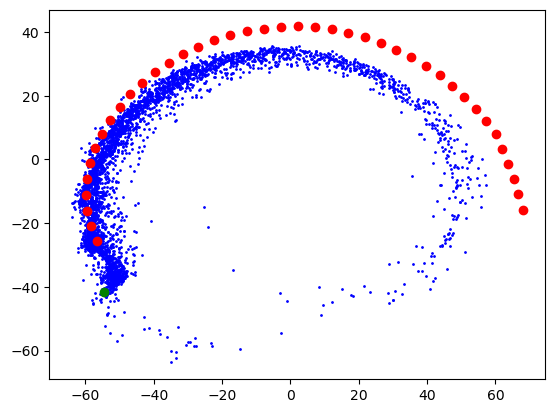

In [116]:
plt.scatter(x_lead, y_lead, c='b', s=1)
plt.scatter(x_lead[arg_in_R], y_lead[arg_in_R], c='orange')
plt.scatter(x_prog, y_prog, c='g')
plt.scatter(x_track, y_track, c='r')


100%|██████████| 500/500 [00:00<00:00, 4087.04it/s]


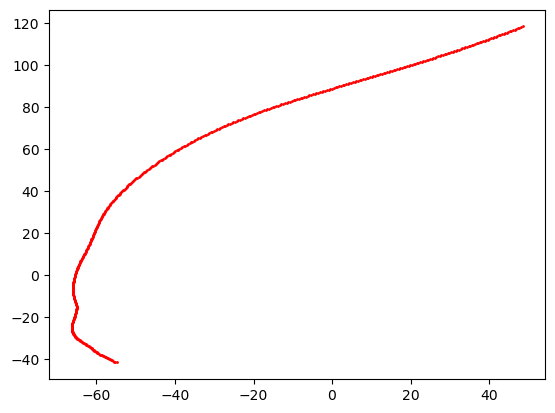

In [225]:
from scipy.interpolate import griddata
from scipy.interpolate import RBFInterpolator


points    = np.column_stack((x_lead, y_lead))
new_point = np.column_stack((prog.x.value, prog.y.value))


# Initialize the RBF interpolator
f_vx = RBFInterpolator(points, vx_lead)
f_vy = RBFInterpolator(points, vy_lead)


x_lead_track = []
y_lead_track = []
dt /= 2
for t in tqdm( range( int( time/4 / dt ) ) ):
    new_vx = f_vx(new_point)
    new_vy = f_vy(new_point)

    x_new_point = new_point[0, 0] * pos_unit + new_vx * dt * vel_unit
    y_new_point = new_point[0, 1] * pos_unit + new_vy * dt * vel_unit

    new_point = np.column_stack((x_new_point.value, y_new_point.value))

    x_lead_track.append(x_new_point)
    y_lead_track.append(y_new_point)
x_lead_track = np.array(x_lead_track)
y_lead_track = np.array(y_lead_track)

plt.scatter(x_lead_track, y_lead_track, s=1, c='r')

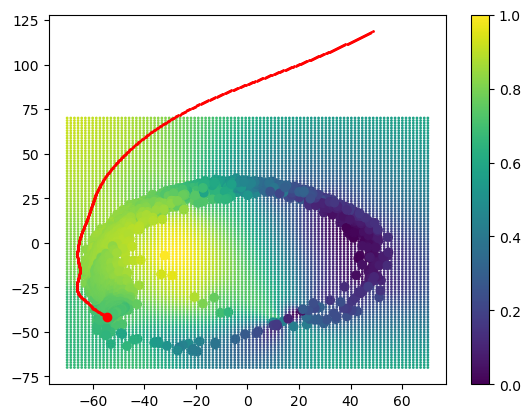

In [227]:
X, Y = np.meshgrid(np.linspace(-70, 70, 100), np.linspace(-70, 70, 100))
VX = f_vx( np.column_stack( (X.flatten(), Y.flatten()) ) ).reshape(X.shape)
VY = f_vy( np.column_stack( (X.flatten(), Y.flatten()) ) ).reshape(X.shape)

plt.scatter(X, Y, s=1, c=VY.flatten())
plt.scatter(x_lead, y_lead, c=vy_lead)
plt.scatter(x_prog, y_prog, c='r') 
plt.scatter(x_lead_track, y_lead_track, s=1, c='r')
plt.colorbar()

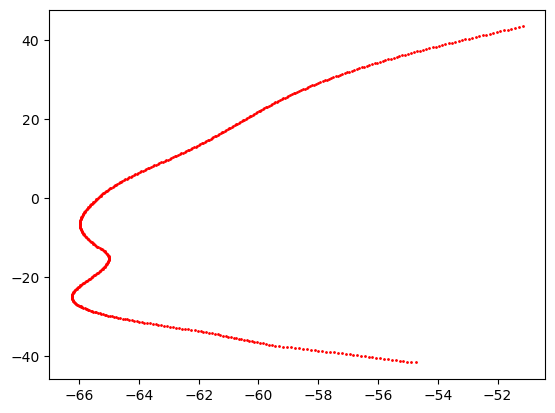

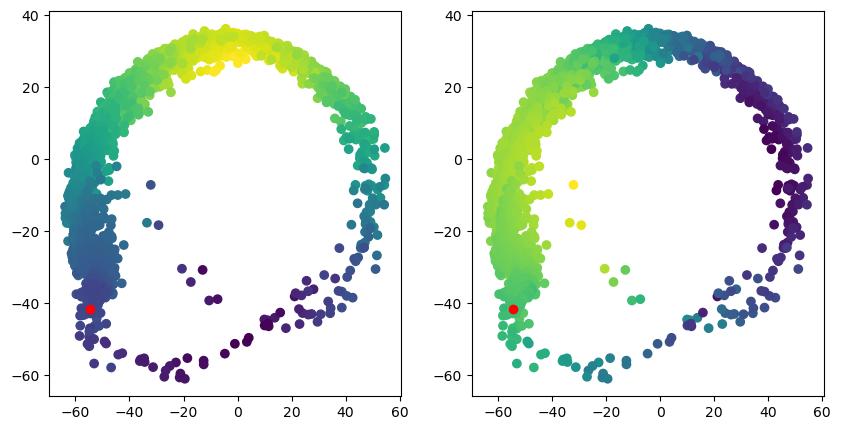

In [203]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.scatter(x_lead, y_lead, c=vx_lead)
plt.scatter(x_prog, y_prog, c='r') 
plt.subplot(1,2,2)
plt.scatter(x_lead, y_lead, c=vy_lead)
plt.scatter(x_prog, y_prog, c='r')

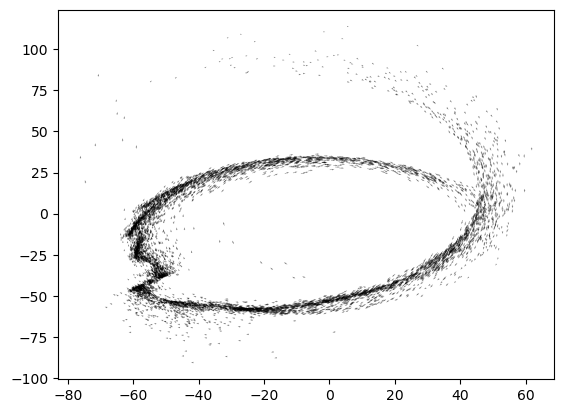

In [134]:
plt.quiver(stream.x.value, stream.y.value, stream.v_x.value, stream.v_y.value, color='k', alpha=0.5, width=0.001)

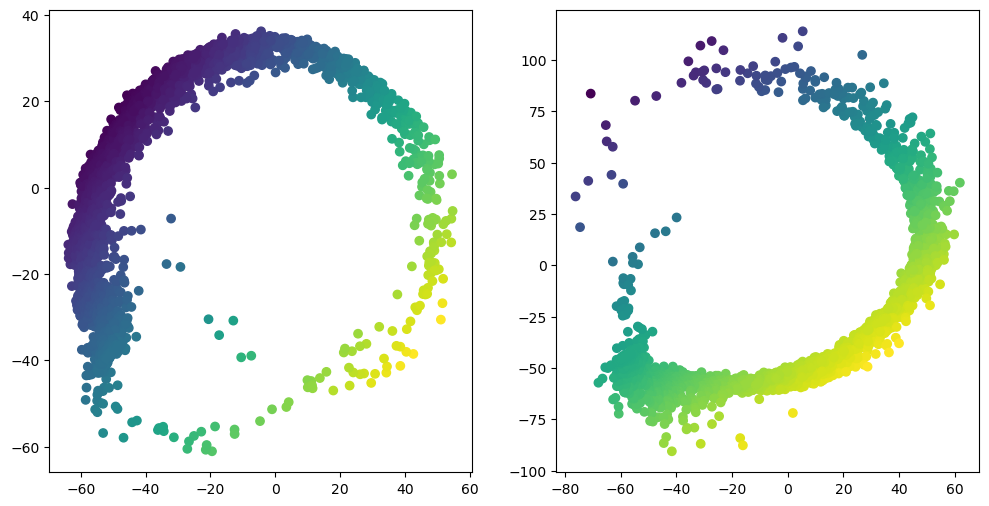

In [121]:
arg_lead  = stream.lead_trail == 'l'
arg_trail = stream.lead_trail == 't'

pca = PCA(n_components=1)
pca.fit(stream.xyz[:2, arg_lead])
gamma_lead = pca.components_[0]
pca = PCA(n_components=1)
pca.fit(stream.xyz[:2, arg_trail])
gamma_trail = pca.components_[0]

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(stream.x[arg_lead], stream.y[arg_lead], c=gamma_lead)
plt.subplot(1,2,2)
plt.scatter(stream.x[arg_trail], stream.y[arg_trail], c=gamma_trail)

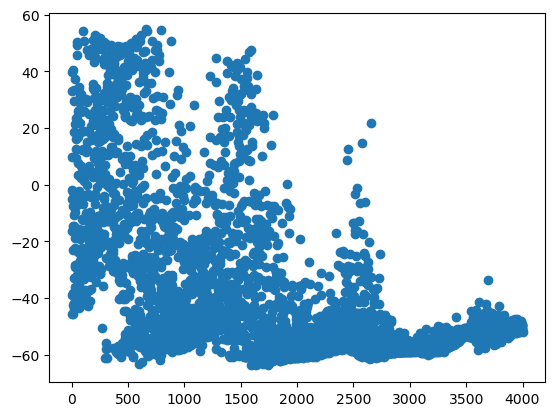

In [67]:
plt.scatter(stream.release_time.value[arg_lead], stream.x[arg_lead])

In [3]:
# Get Nbody stream
Nbody_stream = np.loadtxt('Nbody_stream.txt') * u.kpc

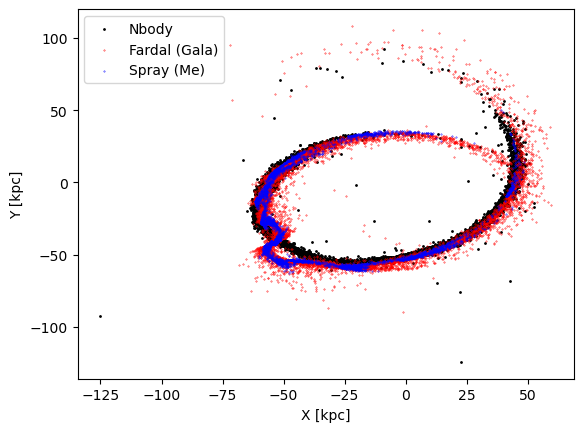

In [5]:
plt.scatter(Nbody_stream[:,0], Nbody_stream[:,1], s=1, c='k', label='Nbody')
plt.scatter(stream.xyz[0], stream.xyz[1], s=.1, c='r', label='Fardal (Gala)')
plt.scatter(orbit_pos_N[-1, :, 0], orbit_pos_N[-1, :, 1], s=.1, c='b', label='Spray (Me)')
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.legend(loc='best')

In [20]:
# Automatic spline fitting
x_stream, y_stream = stream.xyz[:2]
energy = stream.energy(H).to(u.km**2/u.s**2)

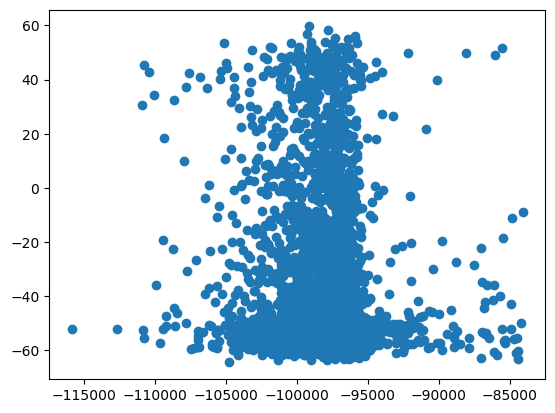

In [58]:
stream.energy(H).to(u.km**2/u.s**2)
# plt.scatter(x_stream, y_stream,c=stream.energy(H).to(u.km**2/u.s**2).value) 
plt.scatter(stream.energy(H).to(u.km**2/u.s**2).value[arg_lead], x_stream[arg_lead])